
## Predicting Home Prices in West Chicago Neighborhoods

#Target Variable: Home Sale Price

## Master Function for Scraping Attirbutes from Listing HTML
* Set up all attributes in individual functions and call a master function (take in list of html objects), iterate through and convert object into a BS, run all attribute funcs on BS, save that to a dictiornary, append that dictionary into a list

Set up func that loops and opens pickle/list of pickles. Iterate through list and convert each html_listing to soup object.
* MVP: 

In [594]:
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from IPython.core.display import display, HTML
import sys
import time
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 1000)
import random
from fake_useragent import UserAgent
import pickle
import re
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
infile = open('listing_html_COMBINED.pkl', 'rb')
listing_html_wp_bt_wt = pickle.load(infile)

### Functions for Scraping Feature Data

In [5]:
def get_address(soup):
    '''
    parameters: bs object
    returns: address, str type, cleaned

    '''
    element = soup.find('h1', class_ = 'ds-address-container')
    #print(element.text.strip())
    address = element.text.strip()
    address = address.replace('Chicago, IL','').strip()
    address = address.replace(',\xa0 ','')
    address = str(address[:-5])
    return address
       

In [7]:
def get_zip_code(soup):
    '''
    parameters: bs object
    returns: zip code, int type, cleaned

    '''
    element = soup.find('h1', class_ = 'ds-address-container')
    #print(element.text.strip())
    zip_code = element.text.strip()
    zip_code = zip_code[-5:]
    return str(zip_code)

In [9]:
def get_listing_status(soup):
    element = soup.find('span', class_ = 'ds-status-icon zsg-icon-recently-sold')
    status = element.next_sibling
    return status

In [11]:
def get_price(soup):
    '''
    parameters: bs object
    returns: sold_price, int type, cleaned
    '''
    element = soup.find('span', class_ = 'ds-status-icon zsg-icon-recently-sold')
    sold_price = element.next_sibling.next_sibling.text
    sold_price = sold_price.replace(':', '')
    sold_price = sold_price.replace('$', '')
    sold_price = sold_price.replace(',', '').strip()
    return sold_price
   

In [14]:
def get_sold_date(soup):
    '''

    parameters: bs object
    returns: sold date, str type, cleaned

    '''
    element = soup.find('span', class_ = 'sc-qZtCU bnePEP')
    #print(element
    sold_date = element.text[-8:]
    #print(sold_date, 'sold date')
    return str(sold_date)

In [16]:
def get_num_bedrooms(soup):
    '''
    parameters: bs object
    returns: num_bedrooms, str type, cleaned

    '''
    element = soup.find(class_ = 'ds-bed-bath-living-area')
    num_bedrooms = element.text
    num_bedrooms = num_bedrooms[0]
    num_bedrooms = num_bedrooms.replace('.', '')
    num_bedrooms = num_bedrooms.strip()
    if num_bedrooms == '-':
        num_bedrooms = np.nan
    return num_bedrooms


In [18]:
def get_num_bathrooms(soup):
    '''
    parameters: bs object
    returns: num_bathrooms, str type, cleaned

    '''
    element = soup.find('h3', class_ = 'ds-bed-bath-living-area-container')
    #print(element.findChildren(), "header" )
    num_bathrooms = [x.text for x in element.findChildren()]
    num_bathrooms = num_bathrooms[4]
    num_bathrooms = num_bathrooms[0:2]
    #num_bathrooms = num_bathrooms.replace('.', '')
    num_bathrooms = num_bathrooms.strip()
    if num_bathrooms == '-':
        num_bathrooms = np.nan
    return num_bathrooms

In [20]:
def get_sq_ft(soup):
    '''
    parameters: bs object
    returns: sqft, int type, cleaned

    '''
    element = soup.find('h3', class_ = 'ds-bed-bath-living-area-container')
    #print(element.findChildren(), "header" )
    sq_ft = [x.text for x in element.findChildren()]
    sq_ft = str(sq_ft[10]).replace(',','')
    sq_ft = sq_ft.replace('Square', '')
    sq_ft = sq_ft.replace('Feet', '')
    sq_ft = sq_ft.replace("'", '')
    sq_ft = sq_ft.replace('sqft', '')
    sq_ft = sq_ft.replace('[', '')
    sq_ft = sq_ft.replace(']', '').strip()
    if sq_ft == '--':
        sq_ft = 'No Data'
    return sq_ft

In [22]:
def get_listing_type(soup):
    '''
    parameters: bs object
    returns: listing_type, str type, cleaned

    '''
    element = soup.find('span', class_ = 'ds-body ds-home-fact-value')
    listing_type = element.text.strip()
    return listing_type

In [24]:
def get_year_built(soup):
    '''
    parameters: bs object
    returns: year_built, int type, cleaned

    '''
    element = soup.find('li', class_ = 'ds-home-fact-list-item')
    year_built = element.next_sibling.text[-4:]
    return year_built

In [26]:
def get_parking(soup):
    '''
    parameters: bs object
    returns: parking, int type, cleaned
    '''
    element = soup.find('li', class_ = 'ds-home-fact-list-item')
    parking = element.next_sibling.next_sibling.next_sibling.next_sibling.text
    parking = parking.replace("Parking:", '')
    parking = parking.replace("space", "").strip()
    parking_values_yes = ['1 s', '2 s', '3 s', '1', '2', '3',
        'Attached Garage', '4 s', '5 s', 'Off street, Detached Garage', 'Carport', '8 s',
        'On street, Attached Garage', 'Off street, Attached Garage',
        'Carport, Off street, On street', '6 s', '34 s', 'Detached Garage']
    parking_values_no = ['No Data', 'Off Street', 'Off street', 'None', 'On street', 'Off street, On street']
    if parking in parking_values_yes:
        parking = 'Y'
    if parking in parking_values_no:
        parking = 'N'
    if parking == 'No Data':
        parking == np.nan
    return parking


In [28]:
def get_hoa_fees(soup):
    '''
    parameters: bs object
    returns: hoa_fees, str type, cleaned
    '''
    element = soup.find('li', class_ = 'ds-home-fact-list-item')
    hoa_fees = element.next_sibling.next_sibling.next_sibling.next_sibling.next_sibling.text
    hoa_fees = ''.join(re.findall(r'\d+', hoa_fees))
    hoa_fees = int(hoa_fees)
    if hoa_fees > 1500:
        hoa_fees = 'N/A'
    return hoa_fees

In [30]:
property_data_dict_list = []


def master_func_features(html_list):
    '''
    parameter: list of html for all properties

    For loop iterates through a single string of HTML, converts object into BS, run master feature funcs on BS object, and        output as a dictionary entry.

    Try/Except: Nan if no value.

    Returns list of dictionaries with property data for each listing in its own dictionary.
    '''
    attribute_soup = []
    for listing_html in html_list:
        attribute_soup.append(BeautifulSoup(listing_html, 'html.parser'))
        #print(len(attribute_soup)) #--->checked number of BS objects in iteration
    for soup in attribute_soup:
        temp_dict = {}
        try:
            temp_dict['Listing_Address'] = get_address(soup)
        except: 
            temp_dict['Listing_Address'] = 'None'
        try:
            temp_dict['Zip_Code'] = get_zip_code(soup)
        except:
            temp_dict['Zip_Code'] = 'None'
        try:
            temp_dict['Listing_Status'] = get_listing_status(soup)
        except:
            temp_dict['Listing_Address'] = 'None'
        try:
            temp_dict['Listing_Type'] = get_listing_type(soup)
        except:
            temp_dict['Listing_Type'] = 'N/A'
        try:
            temp_dict['Price'] = get_price(soup)
        except:
            temp_dict['Price'] = 'N/A'
        try:
            temp_dict['Sold_Date'] = get_sold_date(soup)
        except:
            temp_dict['Sold_Date'] = 'N/A'
        try:
            temp_dict['Num_Bedrooms'] = get_num_bedrooms(soup)
        except:
            temp_dict['Num_Bedrooms'] = 'N/A'
        try:
            temp_dict['Num_Bathrooms']= get_num_bathrooms(soup)
        except:
            temp_dict['Num_Bathrooms']= 'N/A'
        try:
            temp_dict['Sqft'] = get_sq_ft(soup)
        except:
            temp_dict['Sqft'] = 'N/A'
        try:
            temp_dict['Parking'] = get_parking(soup)
        except:
            temp_dict['Parking'] = 'N/A'
        try:
            temp_dict['Hoa_Fees'] = get_hoa_fees(soup)
        except:
            temp_dict['Hoa_Fees'] = 'N/A'
        try:
            temp_dict['Year_Built'] = get_year_built(soup)
        except:
            temp_dict['Year_Built'] = 'N/A'
        property_data_dict_list.append(temp_dict)
       
    return property_data_dict_list
        
        



In [31]:
#Checks that listing_html is a list type
type(listing_html_wp_bt_wt)

list

In [ ]:
#Execute master func and ALL listing html

master_func_features(listing_html_wp_bt_wt)

In [33]:
#Saves dictionary output to CSV

file_name = "%s_%s.csv" % (str(time.strftime("%Y-%m-%d")), 
                           str(time.strftime("%H%M%S")))
columns = ["Listing_Address", "Zip_code", "Listing_Status", "Listing_Type", "Price", "Sold_Date", "Num_Bedrooms", "Num_Bathrooms", "Sqft", "Parking", "Hoa_Fees", "Year_Built"]

pd.DataFrame(property_data_dict_list, columns = columns).to_csv(file_name, index = False, encoding = "UTF-8")

In [501]:
#Assign CSV path to variable

csv_property_dict_cleaned= ('/Users/Tara8082/Desktop/Metis/Project Repos/Project_Two/2020-10-08_144217.csv')


In [502]:
#Load CSV into dataframe with Listing Address as index

df = pd.read_csv(csv_property_dict_cleaned)
df.set_index('Listing_Address', inplace = True)

In [503]:
#2273 entries SOLD HOMES
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2273 entries, 2239 W North Ave APT 3B to None
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Zip_code        0 non-null      float64
 1   Listing_Status  2132 non-null   object 
 2   Listing_Type    2161 non-null   object 
 3   Price           2130 non-null   float64
 4   Sold_Date       2184 non-null   object 
 5   Num_Bedrooms    1892 non-null   float64
 6   Num_Bathrooms   2157 non-null   object 
 7   Sqft            1544 non-null   object 
 8   Parking         2161 non-null   object 
 9   Hoa_Fees        1451 non-null   float64
 10  Year_Built      2161 non-null   object 
dtypes: float64(4), object(7)
memory usage: 213.1+ KB


### EDA

In [506]:
def clean_dataframe(df):    

    #drops zip code
    df.drop(['Zip_code'], axis=1)

    #dropping all columns with price == "N/A"
    df = df[df.Price != 'N/A'] 
    df = df.dropna(subset = ['Price'])      

,Listing_Status,Listing_Type,Price,Sold_Date,Num_Bedrooms,Num_Bathrooms,Sqft,Parking,Hoa_Fees,Year_Built
Listing_Address,,,,,,,,,,
2239 W North Ave APT 3B,Sold,Condo,467000.0,11/24/19,2.0,2,1600,N,219.0,2004
2032 W Pierce Ave APT 3W,Sold,Condo,3200.0,04/05/19,3.0,2,NaN,Y,NaN,1998
1904 W Division St,Sold,Condo,675000.0,04/16/19,NaN,--,NaN,N,NaN,Data
1248 N Hoyne Ave #2,Sold,Condo,530000.0,07/04/18,3.0,2,1800,Y,180.0,2016
1233 N Paulina St,Sold,Single Family,1025000.0,08/27/20,3.0,3,3400,Y,NaN,1908
...,...,...,...,...,...,...,...,...,...,...
None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [507]:
#dropping all columns with price == "N/A"
df = df[df.Price != 'N/A'] 
df = df.dropna(subset = ['Price'])

In [508]:
#Price is a str. Convert to int.
df['Price'] = df['Price'].astype('int')

In [509]:
#drop row if Price is less than 50000 (drops 250 rows)
df = df[df.Price > 50000]

In [510]:
#supporting data to drop anything over $10,000,000 (vacant lots, large pieces of land)
df = df[df.Price < 10000000 ]

In [511]:
df.shape

(2052, 11)

In [513]:
#drop homes with sqft over 20,000 (one row)
i = df.loc[('1235 N Honore St #1E')]
print(i)

Zip_code               NaN
Listing_Status        Sold
Listing_Type         Condo
Price               687500
Sold_Date         05/01/19
Num_Bedrooms             3
Num_Bathrooms            3
Sqft                 26600
Parking                  Y
Hoa_Fees               385
Year_Built            1956
Name: 1235 N Honore St #1E, dtype: object


In [514]:
df.drop('1235 N Honore St #1E', inplace = True)

In [515]:
#confirming dropped row
df.shape

(2051, 11)

In [516]:
#changing Sqft to floats, non-numerics becomes "Nan"
df['Sqft'] = pd.to_numeric(df['Sqft'], errors='coerce')

In [517]:
#drop if Listing is Vacant Land, N/A, or Other
df = df[df.Listing_Type != 'Vacant Land']
df = df[df.Listing_Type != 'N/A']
df = df[df.Listing_Type != 'Other'] #commercial buildings

In [518]:
#dropped 243 rows 

# 2043, 11

df.shape

(2043, 11)

In [519]:
df.dtypes

Zip_code          float64
Listing_Status     object
Listing_Type       object
Price               int64
Sold_Date          object
Num_Bedrooms      float64
Num_Bathrooms      object
Sqft              float64
Parking            object
Hoa_Fees          float64
Year_Built         object
dtype: object

In [520]:
df['Listing_Type'].dtypes

dtype('O')

In [521]:
df.Listing_Type.unique()

array(['Condo', 'Single Family', 'Townhouse', 'Multiple Occupancy',
       'Apartment', 'Multi Family', nan], dtype=object)

In [522]:
#Listing_Type "Nan" count = 39

df['Listing_Type'].isna().sum()

39

In [523]:
df = df.dropna(subset = ['Listing_Type'])

In [524]:
#drops 39 rows to 2004,11
df.shape

(2004, 11)

In [525]:
df['Num_Bedrooms'].unique()

array([ 2., nan,  3.,  4.,  9.,  5.,  6.,  1.,  8.,  7.])

In [526]:
df['Num_Bathrooms'].unique()


array(['2', '--', '3', '2.', '4', '3.', '6', '1', '1.', '7', '5', '8',
       '4.'], dtype=object)

In [527]:
#change "Off street, On Street" to 'N'

df['Parking'].unique()

array(['N', 'Y'], dtype=object)

In [528]:
#converting to seasonality, binning data, .cut

df["Real_Date"] = df["Sold_Date"].astype('string')

In [529]:
df["Date_Time"] = pd.to_datetime(df["Real_Date"])

In [530]:
seasons = pd.cut(df['Date_Time'],4,labels=['Winter','Spring','Summer','Fall'])

In [534]:
type(seasons)

pandas.core.series.Series

In [535]:
df.loc[(df.Num_Bathrooms == '--'),'Num_Bathrooms'] = np.nan

In [536]:
df.dtypes

Zip_code                 float64
Listing_Status            object
Listing_Type              object
Price                      int64
Sold_Date                 object
Num_Bedrooms             float64
Num_Bathrooms             object
Sqft                     float64
Parking                   object
Hoa_Fees                 float64
Year_Built                object
Real_Date                 string
Date_Time         datetime64[ns]
dtype: object

In [537]:
df.isnull().sum()

Zip_code          2004
Listing_Status       0
Listing_Type         0
Price                0
Sold_Date            0
Num_Bedrooms       278
Num_Bathrooms      289
Sqft               856
Parking              0
Hoa_Fees           604
Year_Built           0
Real_Date            0
Date_Time            0
dtype: int64

## Linear Regression: Dropping Sqft if == Nan

*GOAL: Can I improve my validation score?

* way to improve validation score
*   fit standard scaler to train/val, fit to train, test on val
*   OLS stats model (see Anterra's graph)
*   add a feature


* Difference between train and val?
* not much of a difference between train and val data

In [586]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge  #ordinary linear regression + w/ ridge regularization
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error

In [539]:
#df_dropped is new DF that i sdropping columns if Sqft == Nan
df_dropped = df.dropna(subset = ['Sqft']).copy()
#drops 881 rows for total of 1148, 11
#df_dropped.shape

df_dropped = df_dropped.dropna(subset = ['Num_Bedrooms'])
df_dropped = df_dropped.dropna(subset = ['Num_Bathrooms'])

#drops 3 columns for total of 1145, 11
df_dropped.shape

(1145, 13)

In [540]:
#confirming drops of Sqt = Nan
df_dropped.head(15)

,Zip_code,Listing_Status,Listing_Type,Price,Sold_Date,Num_Bedrooms,Num_Bathrooms,Sqft,Parking,Hoa_Fees,Year_Built,Real_Date,Date_Time
Listing_Address,,,,,,,,,,,,,
2239 W North Ave APT 3B,NaN,Sold,Condo,467000,11/24/19,2.0,2,1600.0,N,219.0,2004,11/24/19,2019-11-24
1248 N Hoyne Ave #2,NaN,Sold,Condo,530000,07/04/18,3.0,2,1800.0,Y,180.0,2016,07/04/18,2018-07-04
1233 N Paulina St,NaN,Sold,Single Family,1025000,08/27/20,3.0,3,3400.0,Y,NaN,1908,08/27/20,2020-08-27
2038 W Crystal St #1,NaN,Sold,Condo,695000,04/06/20,3.0,3,2600.0,Y,175.0,2012,04/06/20,2020-04-06
1945 W Evergreen Ave,NaN,Sold,Condo,344000,03/10/20,2.0,2,1500.0,Y,226.0,1886,03/10/20,2020-03-10
1243 N Wolcott Ave APT 5,NaN,Sold,Condo,655000,03/10/19,3.0,3,2000.0,Y,200.0,2000,03/10/19,2019-03-10
1530 N Elk Grove Ave APT M,NaN,Sold,Townhouse,750000,08/11/19,3.0,3,2785.0,Y,840.0,1998,08/11/19,2019-08-11
2117 W Crystal St APT 1,NaN,Sold,Condo,632500,05/14/19,3.0,3,2400.0,Y,170.0,2004,05/14/19,2019-05-14
2020 W Pierce Ave APT 6,NaN,Sold,Condo,525500,06/24/18,3.0,2,1450.0,N,315.0,2002,06/24/18,2018-06-24


In [541]:
#set up model: Features (X), Target (y) = Price

model_df_dropped_sqft_nan = df_dropped[['Price', 'Sqft', 'Parking', 'Listing_Type', 'Num_Bedrooms', 'Num_Bathrooms']] 

model_df_dropped_sqft_nan= pd.get_dummies(model_df_dropped_sqft_nan)

In [543]:
model_df_dropped_sqft_nan.head()

,Price,Sqft,Num_Bedrooms,Parking_N,Parking_Y,Listing_Type_Apartment,Listing_Type_Condo,Listing_Type_Multi Family,Listing_Type_Multiple Occupancy,Listing_Type_Single Family,...,Num_Bathrooms_2,Num_Bathrooms_2.,Num_Bathrooms_3,Num_Bathrooms_3.,Num_Bathrooms_4,Num_Bathrooms_4.,Num_Bathrooms_5,Num_Bathrooms_6,Num_Bathrooms_7,Num_Bathrooms_8
Listing_Address,,,,,,,,,,,,,,,,,,,,,
2239 W North Ave APT 3B,467000,1600.0,2.0,1,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1248 N Hoyne Ave #2,530000,1800.0,3.0,0,1,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1233 N Paulina St,1025000,3400.0,3.0,0,1,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
2038 W Crystal St #1,695000,2600.0,3.0,0,1,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1945 W Evergreen Ave,344000,1500.0,2.0,0,1,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [544]:
def LR_model_dropped_sqft_nan(df):
    
    #df= pd.get_dummies(df)
    
    X, y = df.drop('Price',axis=1), df['Price']

    # test = hold out 20% of the data for final testing
    X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=10)

    # val = hold another 20% of never before seen data to see how well model generalizes
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.25, random_state=3)

    #Scaling features
    scaler = StandardScaler()

    X_train_scaled_sqftdrop = scaler.fit_transform(X_train.values)
    X_val_scaled_sqftdrop = scaler.transform(X_val.values)
    X_test_scaled_sqftdrop = scaler.transform(X_test.values)

    lm = LinearRegression() #defining new LR model
    lm.fit(X_train_scaled_sqftdrop, y_train) #fit to training data


    print(f'Linear Regression val R^2: {lm.score(X_val_scaled_sqftdrop, y_val):.3f}') #score it on validation data
    print(f'Linear Regression train R^2: {lm.score(X_train_scaled_sqftdrop, y_train):.3f}') #score it on training data

In [545]:
#Run regression model for dropping sqft dataset

LR_model_dropped_sqft_nan(model_df_dropped_sqft_nan)

Linear Regression val R^2: 0.643
Linear Regression train R^2: 0.769


## Results

Just price: Linear Regression val R^2: 0.704
Linear Regression train R^2: 0.677

#pairplot

sns.pairplot(model_df_dropped_sqft_nan)

## LR without dropping Sqft Nan (Back into Sqft if Nan by calculating average cost per sqft on train data and using price 

* Create a train/test split of data.
* Find average price/sqft for training data and fill in Nans.
* Fill average price/sqft for val data.
* FIll average price sqft for test dta. 
* Run regression on both to see if improvement in R^2.

In [563]:
#TRAIN, VAL MODEL

def LR_sqft_no_drops(df):
    #adding dummies for Listing_Type and Parking
    #df= pd.get_dummies(df)

    #X, y = df_model_sqft_no_drops.drop('Price',axis=1), df_model_sqft_no_drops['Price']
    X, y = df.drop('Price', axis = 1), df['Price']

    # Hold out 20% of the data for final testing
    X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=10)

    #Training Data: Average Price per Square Foot for Nan Sqft
    # Find mean for all of training data

    sqft_mean_train = X['Sqft'].mean().round(2)  #excludes Nan values
    price_mean_train = y.mean().round(2)  #excludes Nan values
    train_ave_price_per_sqft = (price_mean_train/sqft_mean_train).round(2)

    print(sqft_mean_train, 'is sqft_mean_train.')
    print(price_mean_train, 'is price_mean_train.')
    print(train_ave_price_per_sqft, "is the TRAIN average price per sqft.") 

    df_train_mean = pd.concat([X, y], axis = 1)
    df_train_mean.reset_index().head()
    df_train_mean[df_train_mean.index.duplicated()]
    df_train_mean = df_train_mean[~df_train_mean.index.duplicated()]

    #add price per sqft column to df_train_mean
    df_train_mean['Estimated_Sqft'] = (df_train_mean['Price']/train_ave_price_per_sqft).round(0)
    df_train_mean['Actual_Difference'] = abs(df_train_mean['Estimated_Sqft'] - df_train_mean['Sqft'])

    sqft_difference = df_train_mean['Actual_Difference'].mean().round(0)
    print("The difference in predicted versus actualy square footage is", sqft_difference)

    #filling train_mean_nas with Estimated Sq-ft
    df_train_mean['Sqft'] = df_train_mean['Sqft'].fillna(df_train_mean['Estimated_Sqft'])

    # setting Xdata equal to train_mean_data with no nulls
    X['Sqft'] = df_train_mean['Sqft']

    # Hold out val data with filled in mean
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.25, random_state=3)

    #Scaling features
    scaler2 = StandardScaler()
    X_train_scaled = scaler2.fit_transform(X_train.values)
    X_val_scaled = scaler2.transform(X_val.values)

    lm2 = LinearRegression() #defining new LR model
    lm2.fit(X_train_scaled, y_train) #fit to training data

    #DIFF BETWEEN TRAIN AND VAL
    print(f'Linear Regression val R^2: {lm2.score(X_val_scaled, y_val):.3f}') #score it on validation data
    print(f'Linear Regression train R^2: {lm2.score(X_train_scaled, y_train):.3f}') #score it on training data




In [564]:
df_model_sqft_no_drop = df[['Price', 'Sqft']].copy()
df_model_sqft_no_drop = pd.get_dummies(df_model_sqft_no_drop)

LR_sqft_no_drops(df_model_sqft_no_drop)

2068.97 is sqft_mean_train.
672456.34 is price_mean_train.
325.02 is the TRAIN average price per sqft.
The difference in predicted versus actualy square footage is 410.0
Linear Regression val R^2: 0.963
Linear Regression train R^2: 0.934


In [565]:
df_model_final = df[['Price', 'Sqft', 'Listing_Type', 'Parking', 'Num_Bedrooms', 'Num_Bathrooms']].copy()
df_model_final = df_model_final.dropna(subset = ['Num_Bedrooms'])
df_model_final = df_model_final.dropna(subset = ['Num_Bathrooms'])
df_model_final = pd.get_dummies(df_model_final)


# 1,726 rows when dropping num bed and num bath columns that are null
df_model_final.shape

LR_sqft_no_drops(df_model_final)


2102.67 is sqft_mean_train.
653057.28 is price_mean_train.
310.58 is the TRAIN average price per sqft.
The difference in predicted versus actualy square footage is 427.0
Linear Regression val R^2: 0.765
Linear Regression train R^2: 0.863


### Regression Results: Sqft
* Linear Regression val R^2: 0.963
* Linear Regression train R^2: 0.934

MVP: get started and choose the most important feature based on domain knowledge, nearly perfect score

### Regression Results with Parking, Sqft/Est Sqft, Listing Type, Num Bed, Num Bath, dropping nulls
* Linear Regression val R^2: 0.765 
* Linear Regression train R^2: 0.863

More features, doesn't scale as perfectly, captures more information



In [ ]:
#pair plot

sns.pairplot(df_model_include_bedbath)

In [551]:
df_model_final.corr()

,Price,Sqft,Num_Bedrooms,Listing_Type_Apartment,Listing_Type_Condo,Listing_Type_Multi Family,Listing_Type_Multiple Occupancy,Listing_Type_Single Family,Listing_Type_Townhouse,Parking_N,...,Num_Bathrooms_2,Num_Bathrooms_2.,Num_Bathrooms_3,Num_Bathrooms_3.,Num_Bathrooms_4,Num_Bathrooms_4.,Num_Bathrooms_5,Num_Bathrooms_6,Num_Bathrooms_7,Num_Bathrooms_8
Price,1.000000,0.831197,0.551724,0.045855,-0.481822,0.040953,0.043136,0.525647,0.001647,-0.074250,...,-0.356835,0.007770,0.063379,0.153768,0.362563,0.030913,0.295627,0.234268,0.178428,0.047830
Sqft,0.831197,1.000000,0.697618,-0.019000,-0.559646,-0.012849,-0.013480,0.618735,0.044283,-0.112063,...,-0.493779,-0.013059,0.072627,0.073285,0.467304,0.068028,0.367148,0.254064,0.217642,-0.010577
Num_Bedrooms,0.551724,0.697618,1.000000,-0.085165,-0.520688,0.251376,0.190655,0.461056,0.000159,-0.040197,...,-0.384003,-0.000866,0.170857,0.093108,0.430221,0.023667,0.247362,0.278325,0.117275,-0.037058
Listing_Type_Apartment,0.045855,-0.019000,-0.085165,1.000000,-0.229765,-0.034605,-0.024529,-0.077928,-0.039463,0.119186,...,0.024860,0.082660,-0.059224,-0.016304,-0.060884,-0.003936,-0.027053,-0.016782,-0.011155,-0.003936
Listing_Type_Condo,-0.481822,-0.559646,-0.520688,-0.229765,1.000000,-0.300693,-0.213141,-0.677139,-0.342909,0.000382,...,0.401172,-0.103589,-0.004315,-0.116657,-0.442074,-0.034199,-0.235070,-0.145823,-0.096929,-0.034199
Listing_Type_Multi Family,0.040953,-0.012849,0.251376,-0.034605,-0.300693,1.000000,-0.032101,-0.101984,-0.051646,0.022691,...,-0.075531,0.031438,0.030822,-0.021337,0.042926,-0.005151,0.017889,0.090686,0.069639,-0.005151
Listing_Type_Multiple Occupancy,0.043136,-0.013480,0.190655,-0.024529,-0.213141,-0.032101,1.000000,-0.072290,-0.036608,0.159879,...,-0.047712,0.006922,-0.013170,-0.015125,0.016052,-0.003651,0.048468,0.101054,0.047791,0.160454
Listing_Type_Single Family,0.525647,0.618735,0.461056,-0.077928,-0.677139,-0.101984,-0.072290,1.000000,-0.116302,-0.086977,...,-0.364137,0.060766,-0.070211,0.163821,0.502220,0.050506,0.245072,0.097659,0.077138,-0.011599
Listing_Type_Townhouse,0.001647,0.044283,0.000159,-0.039463,-0.342909,-0.051646,-0.036608,-0.116302,1.000000,-0.058314,...,-0.125576,0.020281,0.150302,0.001401,0.049163,-0.005874,0.038527,-0.000029,-0.016648,-0.005874
Parking_N,-0.074250,-0.112063,-0.040197,0.119186,0.000382,0.022691,0.159879,-0.086977,-0.058314,1.000000,...,-0.003146,0.066403,-0.072919,-0.015282,-0.088488,-0.011172,-0.029270,0.012633,-0.009130,-0.011172


<AxesSubplot:>

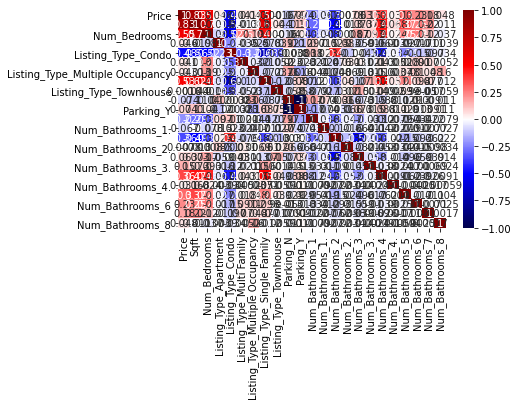

In [552]:
sns.heatmap(df_model_final.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1)

In [605]:
del df_model_final

In [635]:
#FINAL MODEL TESTING

df_model_final = df[['Price', 'Sqft', 'Listing_Type', 'Parking', 'Num_Bedrooms', 'Num_Bathrooms']].copy()
df_model_final = df_model_final.dropna(subset = ['Num_Bedrooms'])
df_model_final = df_model_final.dropna(subset = ['Num_Bathrooms'])
df_model_final = pd.get_dummies(df_model_final)

#X, y = df_model_sqft_no_drops.drop('Price',axis=1), df_model_sqft_no_drops['Price'
X, y = df_model_final.drop('Price', axis = 1), df_model_final['Price']

# Hold out 20% of the data for final testing
X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=10)

#Training Data: Average Price per Square Foot for Nan Sqft
# Find mean for all of training data

sqft_mean_train = X['Sqft'].mean().round(2)  #excludes Nan values
price_mean_train = y.mean().round(2)  #excludes Nan values
train_ave_price_per_sqft = (price_mean_train/sqft_mean_train).round(2)

print(sqft_mean_train, 'is sqft_mean_train.')
print(price_mean_train, 'is price_mean_train.')
print(train_ave_price_per_sqft, "is the TRAIN average price per sqft.") 

df_train_mean = pd.concat([X, y], axis = 1)
df_train_mean.reset_index().head()
df_train_mean[df_train_mean.index.duplicated()]
df_train_mean = df_train_mean[~df_train_mean.index.duplicated()]

#add price per sqft column to df_train_mean
df_train_mean['Estimated_Sqft'] = (df_train_mean['Price']/train_ave_price_per_sqft).round(0)
df_train_mean['Actual_Difference'] = abs(df_train_mean['Estimated_Sqft'] - df_train_mean['Sqft'])

sqft_difference = df_train_mean['Actual_Difference'].mean().round(0)
print("The difference in predicted versus actual square footage for TRAIN DATA is", sqft_difference)

#filling train_mean_nas with Estimated Sq-ft
df_train_mean['Sqft'] = df_train_mean['Sqft'].fillna(df_train_mean['Estimated_Sqft'])

# setting Xdata equal to train_mean_data with no nulls
X['Sqft'] = df_train_mean['Sqft']

# Hold out val data with filled in mean
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.25, random_state=3)

# Scaling features
scaler2 = StandardScaler()
X_train_scaled = scaler2.fit_transform(X_train.values)
X_val_scaled = scaler2.transform(X_val.values)

lm2 = LinearRegression() #defining new LR model
lm2.fit(X_train_scaled, y_train) #fit to training data

# Applying Training Est Sqft to Test Data 
df_test_mean = pd.concat([X_test, y_test], axis = 1)
df_test_mean.reset_index().head()
df_test_mean[df_test_mean.index.duplicated()]
df_test_mean = df_test_mean[~df_test_mean.index.duplicated()]

#add price per sqft column to df_train_mean
df_test_mean['Estimated_Sqft'] = (df_test_mean['Price']/train_ave_price_per_sqft).round(0)
df_test_mean['Actual_Difference'] = abs(df_test_mean['Estimated_Sqft'] - df_test_mean['Sqft'])

sqft_difference = df_test_mean['Actual_Difference'].mean().round(0)
print("The difference in predicted versus actual square footage for TEST DATA is", sqft_difference)

#filling train_mean_nas with Estimated Sq-ft
df_test_mean['Sqft'] = df_test_mean['Sqft'].fillna(df_test_mean['Estimated_Sqft'])

# setting Xdata equal to train_mean_data with no nulls
X_test['Sqft'] = df_test_mean['Sqft']

#Scaling features
X_test_scaled = scaler2.transform(X_test.values)

y_pred = lm2.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)


#DIFF BETWEEN TRAIN AND VAL
print(f'Linear Regression val R^2: {lm2.score(X_val_scaled, y_val):.3f}') #score it on validation data
print(f'Linear Regression train R^2: {lm2.score(X_train_scaled, y_train):.3f}') #score it on training data
print(f'Linear Regression TEST R^2: {lm2.score(X_test_scaled, y_test):.3f}') #score it on training data
print('MSE equals', mse)

2102.67 is sqft_mean_train.
653057.28 is price_mean_train.
310.58 is the TRAIN average price per sqft.
The difference in predicted versus actual square footage for TRAIN DATA is 427.0
The difference in predicted versus actual square footage for TEST DATA is 424.0
Linear Regression val R^2: 0.765
Linear Regression train R^2: 0.863
Linear Regression TEST R^2: 0.774
MSE equals 25310393337.91803


In [612]:
# Get y-intercept
lm2.intercept_ 

662186.392578125

Text(0, 0.5, 'Pesiduals')

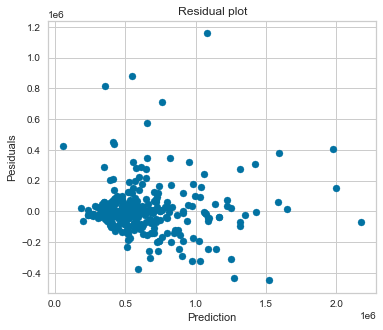

In [636]:
# Linear assumption #1
plt.figure(figsize=(20,5))
    
plt.subplot(1, 3, 2)
res = y_test - y_pred
plt.scatter(y_pred, res)
plt.title("Residual plot")
plt.xlabel("Prediction")
plt.ylabel("Pesiduals")

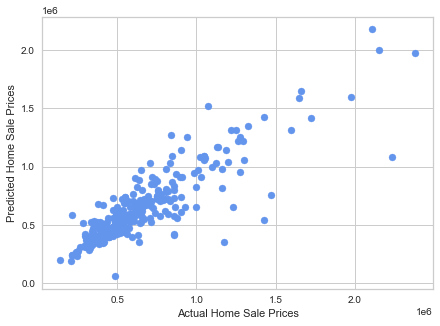

In [639]:

plt.figure(figsize=(7,5))

plt.scatter(y_test, y_pred, color="Cornflowerblue")

plt.xlabel("Actual Home Sale Prices")
plt.ylabel("Predicted Home Sale Prices")
plt.savefig('plot.png')

In [622]:
pip install yellowbrick

     |████████████████████████████████| 263 kB 1.8 MB/s 
Note: you may need to restart the kernel to use updated packages.


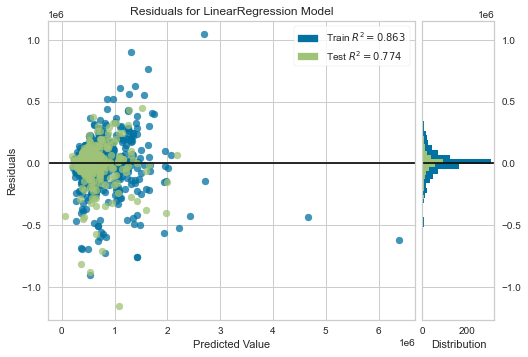

<AxesSubplot:title={'center':'Residuals for LinearRegression Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [631]:
from yellowbrick.datasets import load_concrete
from yellowbrick.regressor import ResidualsPlot

# Instantiate the linear model and visualizer
model = LinearRegression()
visualizer = ResidualsPlot(model)

visualizer.fit(X_train_scaled, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test_scaled, y_test)  # Evaluate the model on the test data
visualizer.show()                 # Finalize and render the figure

In [634]:
plt.scatter(X_test_scaled, y_test,  color='black')
plt.plot(X_test_scaled, y_pred, color='blue', linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

ValueError: x and y must be the same size

ValueError: x and y must be the same size